In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np
import re

2023-07-14 01:49:21.735036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_labels(path):
    """Loads the labels file. Supports files with or without index numbers."""
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        labels = {}
        for row_number, content in enumerate(lines):
            pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
            if len(pair) == 2 and pair[0].strip().isdigit():
                labels[int(pair[0])] = pair[1].strip()
            else:
                labels[row_number] = pair[0].strip()
    return labels

def preprocess_image(image_path, type=np.float32):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)
    original_image = img
    if type == np.uint8:
        img = tf.image.convert_image_dtype(img, tf.uint8)
    else:
        img = tf.image.convert_image_dtype(img, tf.float32)
    resized_img = tf.image.resize(img, (HEIGHT, WIDTH))
    resized_img = resized_img[tf.newaxis, :]
    return resized_img, original_image

def set_input_tensor(interpreter, image):
    """Sets the input tensor."""
    tensor_index = interpreter.get_input_details()[0]['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]
    if interpreter.get_input_details()[0]["dtype"]==np.uint8:
        input_scale, input_zero_point = interpreter.get_input_details()[0]["quantization"]
        image = image / input_scale + input_zero_point
    input_tensor[:, :] = image

def get_output_tensor(interpreter, index):
    """Returns the output tensor at the given index."""
    output_details = interpreter.get_output_details()[index]
    tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
    return tensor

def detect_objects(interpreter, image, threshold):
    """Returns a list of detection results, each a dictionary of object info."""
    set_input_tensor(interpreter, image)
    interpreter.invoke()

    # Get all output details
    boxes = get_output_tensor(interpreter, 0)
    classes = get_output_tensor(interpreter, 1)
    scores = get_output_tensor(interpreter, 2)
    count = int(get_output_tensor(interpreter, 3))

    results = []
    for i in range(count):
        if scores[i] >= threshold:
            result = {
                'bounding_box': boxes[i],
                'class_id': classes[i],
                'score': scores[i]
            }
            results.append(result)
    return results

Elapsed time: 63.486595994618256 miliseconds
(800, 1200, 3)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


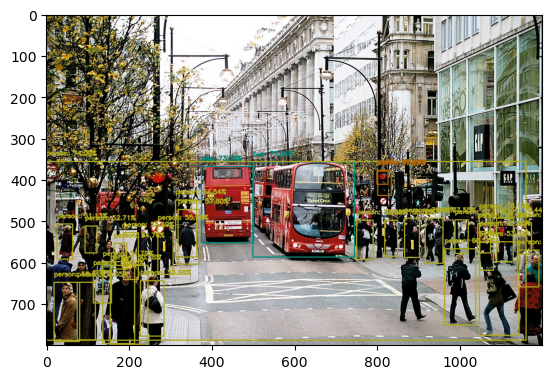

In [3]:
import time
LABELS = load_labels("./coco_labels.txt")
image_path = './images/street.jpg'
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")
tflite_model = '../tflite_models/float32/mobiledet_frozen.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model)
interpreter.allocate_tensors()
_, HEIGHT, WIDTH, _ = interpreter.get_input_details()[0]['shape']

def display_results(image_path, interpreter, threshold=0.3):
    # Load the input image and preprocess it
    input_type = interpreter.get_input_details()[0]['dtype']
    preprocessed_image, original_image = preprocess_image(image_path, input_type)

    # =============Perform inference=====================
    start_time = time.monotonic()
    results = detect_objects(interpreter, preprocessed_image, threshold=threshold)
    print(f"Elapsed time: {(time.monotonic() - start_time)*1000} miliseconds")

    # =============Display the results====================
    original_numpy = original_image.numpy()

    for obj in results:
        # Convert the bounding box figures from relative coordinates
        # to absolute coordinates based on the original resolution
        ymin, xmin, ymax, xmax = obj['bounding_box']
        xmin = int(xmin * original_numpy.shape[1])
        xmax = int(xmax * original_numpy.shape[1])
        ymin = int(ymin * original_numpy.shape[0])
        ymax = int(ymax * original_numpy.shape[0])

        # Grab the class index for the current iteration
        idx = int(obj['class_id'])
        # Skip the background
        if idx >= len(LABELS):
            continue

        # draw the bounding box and label on the image
        color = [int(c) for c in COLORS[idx]]
        cv2.rectangle(original_numpy, (xmin, ymin), (xmax, ymax),
                      color, 2)
        y = ymin - 15 if ymin - 15 > 15 else ymin + 15
        label = "{}: {:.2f}%".format(LABELS[obj['class_id']],
                                     obj['score'] * 100)
        cv2.putText(original_numpy, label, (xmin, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return original_numpy
# Preprocess image and perform inference
resultant_image = display_results(image_path, interpreter, threshold=0.5)
print(resultant_image.shape)
plt.imshow(resultant_image)